In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

In [0]:
from keras.models import Model
from keras.layers import *
from keras.activations import *

In [0]:
def get_gru_last_step(lstm_sequences):
    return Lambda(lambda sequence: sequence[:, -1, :])(lstm_sequences)

def classification_block(input_layer, dropout_rate=0.2):
    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(input_layer)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    model = Dense(256, activation='linear',
                  kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ELU()(model)
    model = Dropout(dropout_rate)(model)

    return Dense(6, activation='sigmoid', kernel_initializer='glorot_normal')(model)

In [0]:
max_words = 30000
max_words_length = 400
embedding_dimension = 300

gru_options = {
    'units': 300,
    'dropout': 0.2,
    'return_sequences': True
}

In [11]:
input_layer = Input(shape=(max_words_length,))

pretrained_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    max_words,
    output_dim=embedding_dimension,
    input_length=max_words_length,
    weights=[np.load('custom_fast_text_embeddings.npy')],
    trainable=False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

averaged_embedding_layer = Average()(
    [pretrained_embedding_layer, custom_embedding_layer])
averaged_embedding_layer = SpatialDropout1D(0.2)(averaged_embedding_layer)

gru = Bidirectional(
  CuDNNGRU(
    units=gru_options['units'],
    return_sequences=gru_options['return_sequences']
  )
)(averaged_embedding_layer)
gru = Dropout(gru_options['dropout'])(gru)

pooled_features = concatenate([
    GlobalMaxPooling1D()(gru),
    GlobalAveragePooling1D()(gru),
    get_gru_last_step(gru)
])

pooled_features = Dropout(0.2)(pooled_features)

output_layer = classification_block(pooled_features, dropout_rate=0.2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='binary_crossentropy', 
            optimizer='Adam',
            metrics=['accuracy'])          

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [12]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 10:13 - loss: 0.1128 - acc: 0.9616

102112/102124 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9755

102124/102124 [==============================] - 822s 8ms/step - loss: 0.0695 - acc: 0.9755 - val_loss: 0.0468 - val_acc: 0.9826
Epoch 2/32
 10144/102124 [=>............................] - ETA: 11:19 - loss: 0.0509 - acc: 0.9815

102112/102124 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9812

102124/102124 [==============================] - 819s 8ms/step - loss: 0.0503 - acc: 0.9812 - val_loss: 0.0422 - val_acc: 0.9839
roc-auc: 0.9888 - roc-auc_val: 0.9857                                                                                                    
Epoch 3/32
  8672/102124 [=>............................] - ETA: 11:38 - loss: 0.0464 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9822

102124/102124 [==============================] - 826s 8ms/step - loss: 0.0465 - acc: 0.9822 - val_loss: 0.0428 - val_acc: 0.9838
Epoch 4/32
 10144/102124 [=>............................] - ETA: 11:27 - loss: 0.0436 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9831

102124/102124 [==============================] - 825s 8ms/step - loss: 0.0442 - acc: 0.9831 - val_loss: 0.0458 - val_acc: 0.9827

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00036602141335606575.
roc-auc: 0.992 - roc-auc_val: 0.988                                                                                                    
Epoch 5/32
  5952/102124 [>.............................] - ETA: 11:59 - loss: 0.0431 - acc: 0.9838

102112/102124 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9837

102124/102124 [==============================] - 825s 8ms/step - loss: 0.0421 - acc: 0.9837 - val_loss: 0.0426 - val_acc: 0.9839
Epoch 6/32
 10144/102124 [=>............................] - ETA: 11:25 - loss: 0.0397 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9842

102124/102124 [==============================] - 825s 8ms/step - loss: 0.0406 - acc: 0.9842 - val_loss: 0.0433 - val_acc: 0.9838
roc-auc: 0.9933 - roc-auc_val: 0.9878                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 11:37 - loss: 0.0376 - acc: 0.9853

102112/102124 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9847

102124/102124 [==============================] - 825s 8ms/step - loss: 0.0390 - acc: 0.9847 - val_loss: 0.0408 - val_acc: 0.9845
Epoch 8/32
 10144/102124 [=>............................] - ETA: 11:26 - loss: 0.0384 - acc: 0.9849

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9852

102124/102124 [==============================] - 826s 8ms/step - loss: 0.0374 - acc: 0.9852 - val_loss: 0.0426 - val_acc: 0.9842
roc-auc: 0.9947 - roc-auc_val: 0.9881                                                                                                    
Epoch 9/32
  8672/102124 [=>............................] - ETA: 11:38 - loss: 0.0351 - acc: 0.9859

102112/102124 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9858

102124/102124 [==============================] - 826s 8ms/step - loss: 0.0357 - acc: 0.9859 - val_loss: 0.0450 - val_acc: 0.9839
Epoch 10/32
 10112/102124 [=>............................] - ETA: 11:27 - loss: 0.0358 - acc: 0.9857

102112/102124 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9863

102124/102124 [==============================] - 826s 8ms/step - loss: 0.0341 - acc: 0.9863 - val_loss: 0.0424 - val_acc: 0.9844
roc-auc: 0.996 - roc-auc_val: 0.9873                                                                                                    
Epoch 11/32
  8672/102124 [=>............................] - ETA: 11:39 - loss: 0.0311 - acc: 0.9880

102112/102124 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9868

102124/102124 [==============================] - 825s 8ms/step - loss: 0.0332 - acc: 0.9868 - val_loss: 0.0428 - val_acc: 0.9843
Epoch 12/32
 10112/102124 [=>............................] - ETA: 11:28 - loss: 0.0312 - acc: 0.9875

102112/102124 [============================>.] - ETA: 0s - loss: 0.0317 - acc: 0.9873

102124/102124 [==============================] - 824s 8ms/step - loss: 0.0317 - acc: 0.9873 - val_loss: 0.0428 - val_acc: 0.9843
roc-auc: 0.9969 - roc-auc_val: 0.9872                                                                                                    
Epoch 13/32
  8672/102124 [=>............................] - ETA: 11:34 - loss: 0.0291 - acc: 0.9892

102112/102124 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9880

102124/102124 [==============================] - 821s 8ms/step - loss: 0.0303 - acc: 0.9880 - val_loss: 0.0427 - val_acc: 0.9843
Epoch 14/32
 10112/102124 [=>............................] - ETA: 11:23 - loss: 0.0299 - acc: 0.9881

102112/102124 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9883

102124/102124 [==============================] - 819s 8ms/step - loss: 0.0292 - acc: 0.9883 - val_loss: 0.0456 - val_acc: 0.9842
roc-auc: 0.9976 - roc-auc_val: 0.9859                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 11:32 - loss: 0.0271 - acc: 0.9891

102112/102124 [============================>.] - ETA: 0s - loss: 0.0282 - acc: 0.9886

102124/102124 [==============================] - 820s 8ms/step - loss: 0.0282 - acc: 0.9886 - val_loss: 0.0465 - val_acc: 0.9840

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.0001166291258414276.
Epoch 16/32
  8032/102124 [=>............................] - ETA: 11:38 - loss: 0.0287 - acc: 0.9884

102112/102124 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9890

102124/102124 [==============================] - 818s 8ms/step - loss: 0.0274 - acc: 0.9890 - val_loss: 0.0463 - val_acc: 0.9841
roc-auc: 0.9982 - roc-auc_val: 0.9862                                                                                                    
Epoch 17/32
  8672/102124 [=>............................] - ETA: 11:33 - loss: 0.0262 - acc: 0.9894

102112/102124 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9894

102124/102124 [==============================] - 821s 8ms/step - loss: 0.0264 - acc: 0.9894 - val_loss: 0.0460 - val_acc: 0.9842


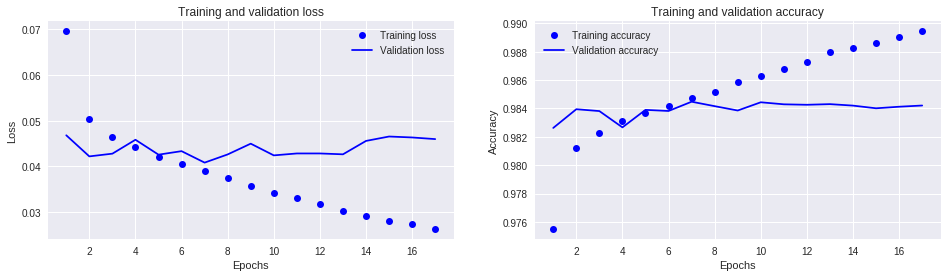

In [13]:
plot_history(history)

In [14]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 81s 3ms/step
([0.0445995239354174, 0.9845057048619065], 0.9885900185887678)
